In [1]:
import pyccl as ccl
import levin
import numpy as np
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline


# Cosmology

cosmo = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=0.7, sigma8=0.8, n_s=0.965)





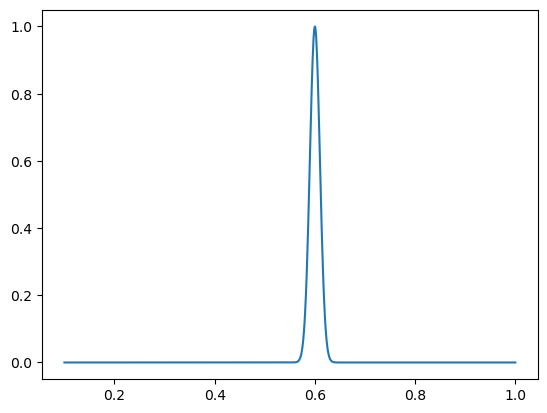

In [2]:
z = np.linspace(0.1, 1, 1000)
nz = np.exp(-0.5*((z-.6)/.01)**2)


b1 = np.ones_like(z)
tracers = {}
tracers['g']  = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z, nz), bias=(z, b1))




ell = np.unique((np.geomspace(2, 150)).astype(int))

plt.plot(z,nz)


In [3]:

chi = ccl.comoving_radial_distance(cosmo,1/(1+z))
kmin, kmax, nk = 1e-4, 1e1, 500
k = np.geomspace((kmin), (kmax), nk) # Wavenumber
pk_nl = []
for zet in z:
    pk_nl.append(ccl.nonlin_matter_power(cosmo, k, 1/(1+zet)))
pk_nl = np.array(pk_nl)


spl = UnivariateSpline(chi, z, k=2, s=0)
dzdchi = spl.derivative()(chi)
norm = 1/np.trapz(nz*dzdchi,chi)
nofchi = dzdchi*nz*norm
idx_non_zero = np.where(nofchi >0)[0]
mean_chi = np.argmin(np.abs(chi - np.trapz(nz*dzdchi*norm*chi,chi)))


In [4]:
cls = ccl.angular_cl(cosmo, tracers['g'], tracers['g'], ell, l_limber = 10009,limber_max_error=0.0001) 
cls1 = ccl.angular_cl(cosmo, tracers['g'], tracers['g'], ell, l_limber = 1,limber_max_error=0.0001)

In [5]:

integral_type = 0
N_thread = 8 # Number of threads used for hyperthreading
logx = True # Tells the code to create a logarithmic spline in x for f(x)
logy = True # Tells the code to create a logarithmic spline in y for y = f(x)
n_sub = 6 #number of collocation points in each bisection
n_bisec_max = 16 #maximum number of bisections usedREISCHKEC
rel_acc = 1e-3 #relative accuracy target
boost_bessel = True #should the bessel functions be calculated with boost instead of GSL, higher accuracy at high Bessel orders
verbose = False #should the code talk to you?

lower_limit = k[0]*np.ones_like(ell)
upper_limit = np.ones_like(ell)

N_int = int(1e3)
k_int = np.geomspace(k[0], 1e0, N_int)

inner_int = np.zeros((len(ell), len(k_int)))
pk_nl_new = np.zeros((len(z), len(k_int)))
for zet_i, zet_val in enumerate(z):
    pk_nl_new[zet_i,:] = (ccl.nonlin_matter_power(cosmo, k_int, 1/(1+zet_val)))

lp_ell = []
lower_limit = chi[idx_non_zero[0]]*np.ones_like(k_int)
upper_limit = chi[idx_non_zero[-1]]*np.ones_like(k_int)

t0 = time.time()
for i_ell, val_ell in enumerate(ell):
    lp = levin.levin(integral_type, chi[idx_non_zero], np.sqrt(pk_nl_new[idx_non_zero,:])*nofchi[idx_non_zero,None], logx, logy, N_thread)
    lp_ell.append(lp)
    lp_ell[i_ell].set_levin(n_sub, n_bisec_max, rel_acc, boost_bessel, verbose)
    ell_values = (val_ell*np.ones_like(k_int)).astype(int)
    lp_ell[i_ell].levin_integrate_bessel_single(lower_limit, upper_limit, k_int, ell_values, True, inner_int[i_ell,:])
print("Levin took", time.time() -t0, "s")
t0 = time.time()
for i_ell, val_ell in enumerate(ell):
    ell_values = (val_ell*np.ones_like(k_int)).astype(int)
    lp_ell[i_ell].levin_integrate_bessel_single(lower_limit, upper_limit, k_int, ell_values, True, inner_int[i_ell,:])
print("Levin took", time.time() -t0, "s")
t0 = time.time()
for i_ell, val_ell in enumerate(ell):
    ell_values = (val_ell*np.ones_like(k_int)).astype(int)
    lp_ell[i_ell].levin_integrate_bessel_single(lower_limit, upper_limit, k_int, ell_values, True, inner_int[i_ell,:])
print("Levin took", time.time() -t0, "s")

    
    




Levin took 4.63621711730957 s
Levin took 2.209404230117798 s
Levin took 0.19858407974243164 s


In [6]:
  
result_levin_second = 2/np.pi*np.trapz(inner_int**2*k_int**2,k_int, axis = -1)

In [7]:
from scipy.special import spherical_jn



N_int = int(1e4)
k_int = np.geomspace(k[0], 1, N_int)
bessel = []
power_alt = []
for i_chi, val_chi in enumerate(chi[idx_non_zero]):
    bessel.append([])
    power = ccl.nonlin_matter_power(cosmo,k_int,1./(1+z[idx_non_zero[i_chi]]))

    power_alt.append(power)
    for ell_i, ell_val in enumerate(ell):
        bessel[i_chi].append(spherical_jn(ell_val,val_chi*k_int)*np.sqrt(power))

bessel = np.array(bessel)
power_alt = np.array(power_alt)
integral_1 = np.trapz(nofchi[idx_non_zero,None, None]*bessel,chi[idx_non_zero], axis=0)
result = 2/np.pi*np.trapz(integral_1**2*k_int**2,k_int, axis = -1)

In [8]:
integ_1 = np.trapz(bessel*(nofchi[idx_non_zero])[:,None, None],chi[idx_non_zero], axis = 0)

result_new = 2/np.pi*np.trapz((integ_1*k_int[None,:])**2,k_int,axis = -1)

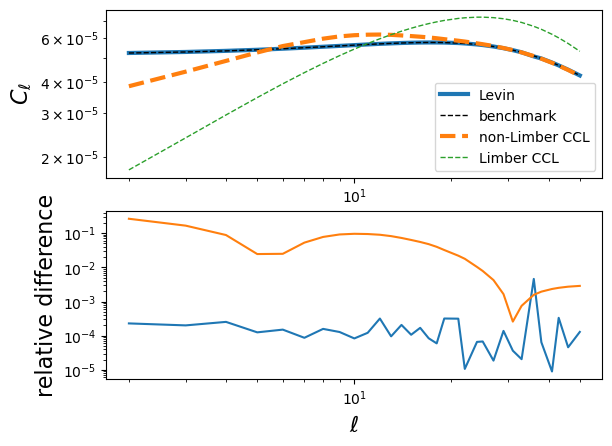

In [9]:
fig, ax = plt.subplots(2)



ax[0].loglog(ell,result_levin_second, ls = "-", label = r"Levin", lw = 3)
ax[0].loglog(ell,result_new, ls = "--", label = r"benchmark", lw= 1, color = "black")

ax[0].loglog(ell,cls, ls = "--", label = r"non-Limber CCL", lw = 3)
ax[0].loglog(ell,cls1, ls = "--", label = r"Limber CCL", lw = 1)

ax[1].loglog(ell, np.abs(result_levin_second- result_new)/result_new)
ax[1].loglog(ell, np.abs(cls - result_new)/result_new)
ax[1].set_xlabel(r"$\ell$", fontsize = 16)
ax[1].set_ylabel("relative difference", fontsize = 16)
#ax[1].set_ylim(-1e-4,1e-4)


ax[1].set_xlabel(r"$\ell$", fontsize = 16)
ax[0].set_ylabel(r"$C_\ell$", fontsize = 16)
ax[0].legend()
